2020-11-14 ~ 2023-08-11


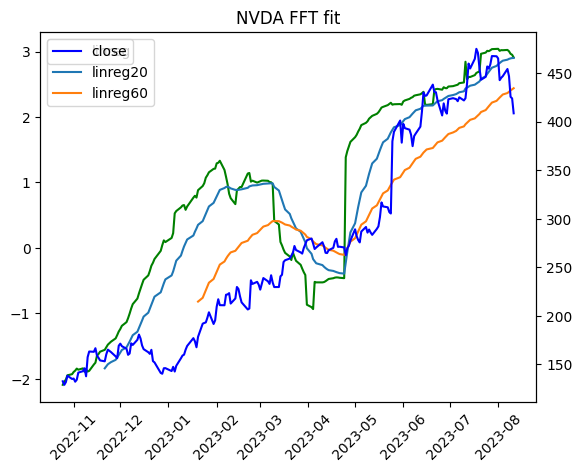

NVDA 129% with 2 buy orders and 2 sell orders


,type,open_time,open_price,close_time,close_price,profit
0,sell,2022-10-25,132.610001,2023-01-20,178.389999,-34.52
1,buy,2023-01-23,191.929993,2023-03-27,265.309998,38.23
2,sell,2023-03-28,264.100006,2023-04-27,272.260010,-3.09
3,buy,2023-04-28,277.489990,2023-08-11,408.549988,47.23


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import sin, cos, sqrt, exp
import yfinance as yf
from datetime import datetime, timedelta
import pandas_ta as ta
def trigfit(x, n, w, m, a, b, xm):
    Sc =0.0
    Ss =0.0
    Scc=0.0
    Sss=0.0
    Scs=0.0
    Sx =0.0
    Sxc=0.0
    Sxs=0.0
    for i in range(n):
        c = cos(w*i)
        s = sin(w*i)
        dx = x[i] - xm[i]
        Sc +=c
        Ss +=s
        Scc+=c*c
        Sss+=s*s
        Scs+=c*s
        Sx +=dx
        Sxc+=dx*c
        Sxs+=dx*s
    Sc /=n
    Ss /=n
    Scc/=n
    Sss/=n
    Scs/=n
    Sx /=n
    Sxc/=n
    Sxs/=n   
    if w == 0 or None:
        m = Sx
        a = 0.0
        b = 0.0
    else:
        den=(Scs-Sc*Ss)**2-(Scc-Sc*Sc)*(Sss-Ss*Ss)
        a=((Sxs-Sx*Ss)*(Scs-Sc*Ss)-(Sxc-Sx*Sc)*(Sss-Ss*Ss))/den
        b=((Sxc-Sx*Sc)*(Scs-Sc*Ss)-(Sxs-Sx*Ss)*(Scc-Sc*Sc))/den
        m=Sx-a*Sc-b*Ss
    return w, m, a ,b 
def freq(x, n, w, m, a, b, xm):
    FreqTOL =0.00009 # 0.00001
    z = [None] * n
    alpha = 0.0 # = beta for initialization
    beta = 2.0
    z[0] = x[0] - xm[0]
    while abs(alpha - beta) > FreqTOL:
        alpha = beta
        z[1] = x[1] = xm[1] + alpha * z[0]
        num = z[0] * z[1]
        den = z[0] * z[0]
        for i in range(2, n):
            z[i] = x[i] - xm[i] + alpha*z[i-1] - z[i-2]
            num += z[i-1]*(z[i]+z[i-2])
            den+=z[i-1]*z[i-1]
        beta = num/den
    if -1 <= beta/2.0 <= 1:
        w = np.arccos(beta/2.0)
    else:
        w= 0 
    w, m, a, b = trigfit(x, n, w, m, a, b, xm)
    return w, m, a, b
def main_v2(ticker, close, day):
    start =  datetime.now()- timedelta(days=1000)
    end = datetime.now() - timedelta(days=day)
    # print(start.strftime("%Y-%m-%d"), "~", end.strftime("%Y-%m-%d"))
    # shop = yf.download(ticker, start= start, end = end, interval = "1d", progress=False)
    av = 0.0

    past = 300
    pred = 100
    # past closed price
    x = [None] * 300

    # average price for the past 300(past) days
    xm = [None] * 300
    ym = [None] * 101
    # print(len(x), len(close))
    for i in range(past):
        x[i] = close[i]
        av += x[i]
    av/=past

    for i in range(past):
        xm[i] = av
        if(i <= pred):
            ym[i] = av
    harmonics = 20
    w = 0.0
    m = 0.0
    a = 0.0
    b = 0.0
    for i in range(1, harmonics + 1):
        w, m, a, b = freq(x, past, w, m, a, b, xm)
        for i in range(past):
            xm[i] += m+a*cos(w*i) + b*sin(w*i)
            if(i <= pred):
                ym[i] += m+a*cos(w*i)-b*sin(w*i)
    return ym


def get_signal(df):
    if df["EMA_20"] - df["EMA_60"] > 0:
# df['linreg'] > 0.2
        return 1
    else:
        return 0
def main_v3(day=200, test_len=200, ticker="NVDA"):
    start =  datetime.now()- timedelta(days=1000+day)
    end = datetime.now() - timedelta(days=day)
    print(start.strftime("%Y-%m-%d"), "~", end.strftime("%Y-%m-%d"))
    shop = yf.download(ticker, start= start, end = end, interval = "1d", progress=False)
    close = shop['Close']
    linregress_array = [None] * test_len

    for i in range(test_len):
        # 1/30 => 1/29 => 1/28 => ...
        close1 = close[::-1][i:i+300]
        a = main_v2(ticker, close1, 0)
        r = np.polyfit(np.arange(0, len(a), 1), a, 1)[0]
        linregress_array[i] = r

    show = [i if i != 0 else 1 for i in linregress_array]
    ma1 = 20
    ma2 = 60
    # print(linregress_array)
    fig, ax1 = plt.subplots()
    df = pd.DataFrame({'close':close[-test_len:], 'linreg':show[::-1]}, index=close.index[-test_len:])
    df.ta.ema(close='linreg', length=ma1, append=True)
    df.ta.ema(close='linreg', length=ma2, append=True)
    df['Signal'] = df.apply(get_signal, axis=1)
    ax2 = ax1.twinx()
    ax1.plot(close.index[-test_len:], show[::-1], 'g-', label='linreg')
    ax1.plot(close.index[-test_len:], df[f'EMA_{ma1}'], label=f'linreg{ma1}')
    ax1.plot(close.index[-test_len:], df[f'EMA_{ma2}'], label=f'linreg{ma2}')
    ax2.plot(close.index[-test_len:], close[-test_len:], 'b-', label='close')
    ax1.tick_params(axis='x', rotation=45)
    plt.title(f"{ticker} FFT fit")
    ax1.legend()
    ax2.legend()
    plt.show()
    res = backtest_manual(df, ticker)
    return res
   

def backtest_manual(df, ticker):
    log_profit = 1
    order = None
    orders_buy = 0
    orders_sell = 0
    df_output = []
    df_temp_output = []
    for i in range(len(df['Signal'])):
        if df['Signal'][i] == 1 and order == None:
            open_price = df['close'][i]
            order = "buy"
            df_temp_output.append(order)
            df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
            df_temp_output.append(open_price)
        elif df['Signal'][i] == 0 and order == "buy":
            close_price = df['close'][i]
            profit = (close_price - open_price)/open_price
            log_profit *= (1+profit)
            order = None
            orders_buy += 1
            df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
            df_temp_output.append(close_price)
            df_temp_output.append(round(profit*100, 2))
            df_output.append(df_temp_output)
            df_temp_output = []
        elif df['Signal'][i] == 0 and order == None:
            open_price = df['close'][i]
            order = 'sell'
            df_temp_output.append(order)
            df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
            df_temp_output.append(open_price)
        elif df['Signal'][i] == 1 and order == 'sell':
            close_price = df['close'][i]
            profit = -(close_price - open_price)/open_price
            log_profit *= (1+profit)
            order = None
            orders_sell += 1
            df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
            df_temp_output.append(close_price)
            df_temp_output.append(round(profit*100, 2))
            df_output.append(df_temp_output)
            df_temp_output = []
    if order == 'buy' or order == 'sell':
        close_price = df['close'][-1]
        if order == 'sell':
            profit = -(close_price - open_price)/open_price
            log_profit *= (1+profit)
            orders_sell += 1
        elif order == 'buy':
            profit = (close_price - open_price)/open_price
            log_profit *= (1+profit)
            orders_buy += 1
        df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
        df_temp_output.append(close_price)
        df_temp_output.append(round(profit*100, 2))
        df_output.append(df_temp_output)
        df_temp_output = []
        order = None
    print(f"{ticker} {int(log_profit*100)}% with {orders_buy} buy orders and {orders_sell} sell orders")
    df_final = pd.DataFrame(df_output, columns=['type', 'open_time', 'open_price', 'close_time', 'close_price', 'profit'])
    return df_final
main_v3(day=200, test_len=200, ticker="NVAX")

2021-06-02 ~ 2024-02-27


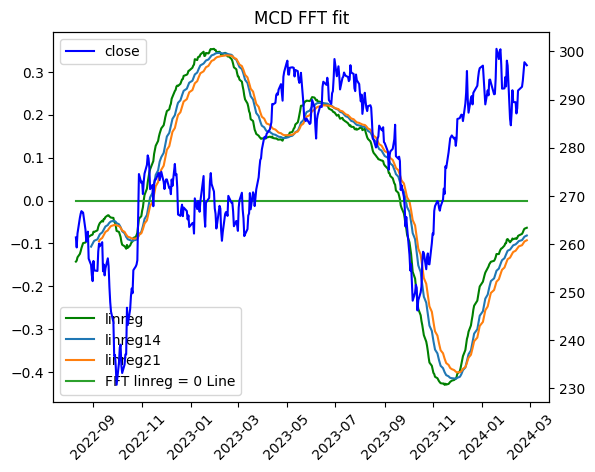

MCD 65% with 4 buy orders and 4 sell orders


,type,open_time,open_price,close_time,close_price,profit
0,sell,2022-08-10,261.359985,2022-09-08,260.079987,0.49
1,buy,2022-09-09,259.519989,2022-10-06,234.750000,-9.54
2,sell,2022-10-07,233.190002,2022-10-28,274.519989,-17.72
3,buy,2022-10-31,272.660004,2023-02-24,263.679993,-3.29
4,sell,2023-02-27,264.779999,2023-05-12,296.140015,-11.84
5,buy,2023-05-15,295.899994,2023-06-29,294.470001,-0.48
6,sell,2023-06-30,298.410004,2023-12-12,291.420013,2.34
7,buy,2023-12-13,295.929993,2024-02-26,297.119995,0.40


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import sin, cos, sqrt, exp
import yfinance as yf
from datetime import datetime, timedelta
import pandas_ta as ta
def trigfit(x, n, w, m, a, b, xm):
    Sc =0.0
    Ss =0.0
    Scc=0.0
    Sss=0.0
    Scs=0.0
    Sx =0.0
    Sxc=0.0
    Sxs=0.0
    for i in range(n):
        c = cos(w*i)
        s = sin(w*i)
        dx = x[i] - xm[i]
        Sc +=c
        Ss +=s
        Scc+=c*c
        Sss+=s*s
        Scs+=c*s
        Sx +=dx
        Sxc+=dx*c
        Sxs+=dx*s
    Sc /=n
    Ss /=n
    Scc/=n
    Sss/=n
    Scs/=n
    Sx /=n
    Sxc/=n
    Sxs/=n   
    if w == 0 or None:
        m = Sx
        a = 0.0
        b = 0.0
    else:
        den=(Scs-Sc*Ss)**2-(Scc-Sc*Sc)*(Sss-Ss*Ss)
        a=((Sxs-Sx*Ss)*(Scs-Sc*Ss)-(Sxc-Sx*Sc)*(Sss-Ss*Ss))/den
        b=((Sxc-Sx*Sc)*(Scs-Sc*Ss)-(Sxs-Sx*Ss)*(Scc-Sc*Sc))/den
        m=Sx-a*Sc-b*Ss
    return w, m, a ,b 
def freq(x, n, w, m, a, b, xm):
    FreqTOL =0.00009 # 0.00001
    z = [None] * n
    alpha = 0.0 # = beta for initialization
    beta = 2.0
    z[0] = x[0] - xm[0]
    while abs(alpha - beta) > FreqTOL:
        alpha = beta
        z[1] = x[1] = xm[1] + alpha * z[0]
        num = z[0] * z[1]
        den = z[0] * z[0]
        for i in range(2, n):
            z[i] = x[i] - xm[i] + alpha*z[i-1] - z[i-2]
            num += z[i-1]*(z[i]+z[i-2])
            den+=z[i-1]*z[i-1]
        beta = num/den
    if -1 <= beta/2.0 <= 1:
        w = np.arccos(beta/2.0)
    else:
        w= 0 
    w, m, a, b = trigfit(x, n, w, m, a, b, xm)
    return w, m, a, b
def main_v2(ticker, close, day):
    start =  datetime.now()- timedelta(days=1000)
    end = datetime.now() - timedelta(days=day)
    # print(start.strftime("%Y-%m-%d"), "~", end.strftime("%Y-%m-%d"))
    # shop = yf.download(ticker, start= start, end = end, interval = "1d", progress=False)
    av = 0.0

    past = 300
    pred = 100
    # past closed price
    x = [None] * 300

    # average price for the past 300(past) days
    xm = [None] * 300
    ym = [None] * 101
    # print(len(x), len(close))
    for i in range(past):
        x[i] = close[i]
        av += x[i]
    av/=past

    for i in range(past):
        xm[i] = av
        if(i <= pred):
            ym[i] = av
    harmonics = 20
    w = 0.0
    m = 0.0
    a = 0.0
    b = 0.0
    for i in range(1, harmonics + 1):
        w, m, a, b = freq(x, past, w, m, a, b, xm)
        for i in range(past):
            xm[i] += m+a*cos(w*i) + b*sin(w*i)
            if(i <= pred):
                ym[i] += m+a*cos(w*i)-b*sin(w*i)
    return ym
day = 1000
test_len = 180
ticker = "MCD"
start =  datetime.now()- timedelta(days=day)
end = datetime.now() #- timedelta(days=day)
print(start.strftime("%Y-%m-%d"), "~", end.strftime("%Y-%m-%d"))
shop = yf.download(ticker, start= start, end = end, interval = "1d", progress=False)
close = shop['Close']
test_len = len(close) - 300
linregress_array = [None] * test_len

for i in range(test_len):
    # 1/30 => 1/29 => 1/28 => ...
    close1 = close[::-1][i:i+300]
    a = main_v2(ticker, close1, 0)
    r = np.polyfit(np.arange(0, len(a), 1), a, 1)[0]
    linregress_array[i] = r

show = [i if i != 0 else 1 for i in linregress_array]
ma1 = 14
ma2 = 21
# print(linregress_array)
fig, ax1 = plt.subplots()
df = pd.DataFrame({'close':close[-test_len:], 'linreg':show[::-1]}, index=close.index[-test_len:])
df.ta.ema(close='linreg', length=ma1, append=True)
df.ta.ema(close='linreg', length=ma2, append=True)

ax2 = ax1.twinx()
ax1.plot(close.index[-test_len:], show[::-1], 'g-', label='linreg')
ax1.plot(close.index[-test_len:], df[f'EMA_{ma1}'], label=f'linreg{ma1}')
ax1.plot(close.index[-test_len:], df[f'EMA_{ma2}'], label=f'linreg{ma2}')
ax1.plot(close.index[-test_len:], [0]*len(df[f'EMA_{ma2}']), label=f"FFT linreg = 0 Line")
ax2.plot(close.index[-test_len:], close[-test_len:], 'b-', label='close')
ax1.tick_params(axis='x', rotation=45) 
plt.title(f"{ticker} FFT fit")
ax1.legend()
ax2.legend()
plt.show()

def get_signal(df):
    if df[f"EMA_{ma1}"] - df[f"EMA_{ma2}"] > 0:
# df['linreg'] > 0.2
        return 1
    else:
        return 0
df['Signal'] = df.apply(get_signal, axis=1)
current = 0
log_profit = 1
order = None
orders_buy = 0
orders_sell = 0
df_output = []
df_temp_output = []
for i in range(len(df['Signal'])):
    if df['Signal'][i] == 1 and order == None:
        open_price = df['close'][i]
        order = "buy"
        df_temp_output.append(order)
        df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
        df_temp_output.append(open_price)
    elif df['Signal'][i] == 0 and order == "buy":
        close_price = df['close'][i]
        profit = (close_price - open_price)/open_price
        log_profit *= (1+profit)
        order = None
        orders_buy += 1
        df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
        df_temp_output.append(close_price)
        df_temp_output.append(round(profit*100, 2))
        df_output.append(df_temp_output)
        df_temp_output = []
    elif df['Signal'][i] == 0 and order == None:
        open_price = df['close'][i]
        order = 'sell'
        df_temp_output.append(order)
        df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
        df_temp_output.append(open_price)
    elif df['Signal'][i] == 1 and order == 'sell':
        close_price = df['close'][i]
        profit = -(close_price - open_price)/open_price
        log_profit *= (1+profit)
        order = None
        orders_sell += 1
        df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
        df_temp_output.append(close_price)
        df_temp_output.append(round(profit*100, 2))
        df_output.append(df_temp_output)
        df_temp_output = []
if order == 'buy' or order == 'sell':
    close_price = df['close'][-1]
    if order == 'sell':
        profit = -(close_price - open_price)/open_price
        log_profit *= (1+profit)
        orders_sell += 1
    elif order == 'buy':
        profit = (close_price - open_price)/open_price
        log_profit *= (1+profit)
        orders_buy += 1
    df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
    df_temp_output.append(close_price)
    df_temp_output.append(round(profit*100, 2))
    df_output.append(df_temp_output)
    df_temp_output = []
    order = None
print(f"{ticker} {int(log_profit*100)}% with {orders_buy} buy orders and {orders_sell} sell orders")
df_final = pd.DataFrame(df_output, columns=['type', 'open_time', 'open_price', 'close_time', 'close_price', 'profit'])
df_final